In [2]:
from PIL import Image
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
import numpy as np
%matplotlib inline

## Get all of the images in the same size so they can all be processed and given the same metrics and get the same effect

In [3]:
def standardize_image(image, target_height=600, target_width=900):
    # Get current dimensions
    height, width = image.shape[:2]
    
    #Calculate scaling factors for both dimensions
    height_scale = target_height / height
    width_scale = target_width / width
    
    # se the smaller scaling factor to maintain aspect ratio
    scale = min(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = int(height * scale)
    new_width = int(width * scale)
    
    # Resize image
    standardized = cv2.resize(image, (new_width, new_height))
    
    # Create a black canvas of target size
    final_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    # Calculate positioning to center the image
    y_offset = (target_height - new_height) // 2
    x_offset = (target_width - new_width) // 2
    
    # Place the resized image in the center of the canvas
    final_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = standardized
    
    return final_image

## Get parking lines and cars and try to isolate parking lines.
- reads image in and erodes parking lines away so you only have the cars and noise.
- dilates cars and noise so they are around biig enough to resemble the cars in the original binary image.
- xors with original binary image to try get rid of cars and noise and only be left with car lines.

In [4]:
def detect_white_lines(img):
    # Convert to HSV for better white line detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range for white color in HSV
    lower_white = np.array([0, 0, 155])                                                            #Different threshold compared to set 1 
    upper_white = np.array([170, 30, 255])
    #Create mask
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0][0].imshow(white_mask, cmap='gray')
    axes[0][0].set_title('Original White Mask')
    axes[0][0].axis('off')
    
    # Open the image to isolate the white blobs and remove the thin white lines
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,5))                                   ###Different kernel size compared to set 1
    car_blobs = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel_car, iterations=1)
    
    axes[0][1].imshow(car_blobs, cmap='gray')
    axes[0][1].set_title('Dilated Blobs')
    axes[0][1].axis('off')
    
     #Dilate Blobs to get them the same size as before we opened tehm above for the xor operation
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))                                    ###Different kernel size compared to set 1
    car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=5)              ###Different iterations compared to set 1
    
    axes[0][2].imshow(car_blobs, cmap='gray')
    axes[0][2].set_title('Eroded Blobs')
    axes[0][2].axis('off')
    
    # AND between original and inverted car blobs to keep only lines
    car_mask = cv2.bitwise_not(car_blobs)
    just_lines = cv2.bitwise_and(white_mask, car_mask)
    
    axes[1][0].imshow(car_mask, cmap='gray')
    axes[1][0].set_title('Car Mask (Inverted)')
    axes[1][0].axis('off')
    
    # Clean up the lines
    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    cleaned_lines = cv2.morphologyEx(just_lines, cv2.MORPH_CLOSE, kernel_line, iterations=20)
    
    axes[1][1].imshow(just_lines, cmap='gray')
    axes[1][1].set_title('Lines Only')
    axes[1][1].axis('off')
    
    
    plt.tight_layout()
    plt.show()
    
    return just_lines

## Once we have parking lines isolated try to improve their visibility so cropping can take place. 
- Firstly blur the image to try minimise nosie.
- Carry out edge detection to impose teh parking lines and get rid of nosie that isn't a majopor edge. 
- Carry out hough transform to try and build lines and join themm together 
- Do dilation and erosion to make the lines stand out a little more before cropping. 

In [5]:
def detect_parking_lines(img):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    #Apply edge detection to the system to detect lines can create a little bit of noise but makes lines more visible before Hough transform 
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    axes[0][0].imshow(edges, cmap='gray')
    axes[0][0].set_title('Edge Detection')
    axes[0][0].axis('off')
    
    #Use Hough transform to connect the lines that have now been detected and connect some of the gaps between the lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=20,#40 #20 medium
        minLineLength=40,  # Minimum length of line
        maxLineGap=50 #50      # Maximum gap between line segments
    )
    
    # Create separate images for horizontal and vertical lines
    horizontal_lines = np.zeros_like(gray)
    vertical_lines = np.zeros_like(gray)
    
    ##carry out operation which only includes horizontal and vertical lines in the image this should reduce noise. Remeber diagonal images coming up
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate line angle
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi)
            
            # Calculate line length
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # Classify lines based on angle
            if (angle < 20) or (angle > 160):  # Horizontal lines
                if length > 100:  # Filter by minimum length
                    cv2.line(horizontal_lines, (x1, y1), (x2, y2), 255, 2)
            elif (70 < angle < 110):  # Vertical lines
                if length > 50:  # Filter by minimum length
                    cv2.line(vertical_lines, (x1, y1), (x2, y2), 255, 2)
    
    axes[0][1].imshow(horizontal_lines, cmap='gray')
    axes[0][1].set_title('Horizontal Lines')
    axes[0][1].axis('off')
    
    axes[0][2].imshow(vertical_lines, cmap='gray')
    axes[0][2].set_title('Vertical Lines')
    axes[0][2].axis('off')
    
    #Combine horizontal and vertical lines
    combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)
    
    #Clean up the lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned_lines = cv2.morphologyEx(combined_lines, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    axes[1][0].imshow(cleaned_lines, cmap='gray')
    axes[1][0].set_title('Combined Lines')
    axes[1][0].axis('off')
        
    # Hide unused subplot
    axes[1][1].axis('off')  ##Two axises were used for operations but operations didn't have positive impact on the image
    axes[1][2].axis('off')
    plt.tight_layout()
    plt.show()
    
    return cleaned_lines

In [13]:
def get_birds_eye_view(image):
    """
    Apply perspective transform to cropped parking area with adjusted points
    """
    height, width = image.shape[:2]
    
    #Adjusted source points for specific image 
    src_points = np.float32([
        [0, height-10],       #Bottom left 
        [width+20, height], # Bottom right 
        [width * 0.95, 5],    #Top righgt
        [0+5, 5]     # Top left
    ])
    
    # Destination points - making a perfect rectangle
    dst_points = np.float32([
        [0, height-1],        # Bttom left
        [width+20, height-1],  #Bottom right 
        [width+20, -30],         # Top right
        [0, 0]                #Top left
    ])
    
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    
    return warped

## Crop image to only detect parking spaces
Try crop the parking regions out based on the vertiical and horizontal lines that have been created in the previous method so we are only left with parking spaces and cars it should be alot easier to then see the occupancy of parkking spaces. 

In [7]:
def crop_parking_regions(parking_area, original_img):
    height, width = parking_area.shape[:2]
    padding_y = 0
    padding_x = 20
    
    # Get projections
    horizontal_projections = np.sum(parking_area, axis=1) #Basically add up all the rows and columns and see how many white pixels is in them 
    vertical_projections = np.sum(parking_area, axis=0)
    
    # Normalize projections
    horizontal_projections = horizontal_projections / width #Need to normalise these values in order to be able threshold them
    vertical_projections = vertical_projections / height
    
    #Find horizontal lines
    horizontal_lines = np.where(horizontal_projections > 0.15)[0]  ##Anywhere where the projection is greater than 0.15 we will consider it a line in vertical or horizontal directi
    vertical_lines = np.where(vertical_projections > 0.15)[0]
    
    #Group horizontal lines by proximity
    grouped_lines = []
    current_group = [horizontal_lines[0]]
    
    for i in range(1, len(horizontal_lines)):
        if horizontal_lines[i] - horizontal_lines[i-1] < 20: #If the distance between one line and another is under 20 see it as the same parking area
            current_group.append(horizontal_lines[i])
        else:
            grouped_lines.append(current_group)
            current_group = [horizontal_lines[i]]
    grouped_lines.append(current_group)
    
    #Create regions from groups
    crop_coordinates = [] 
    min_region_height = height * 0.15 ##,inimum height of a parking region has t be 15% of image height to prevent small croppings
    
    # Find x boundaries using vertical lines
    x_start = max(0, vertical_lines[0] - padding_x)  ##making sure start and end is within the image bounds
    x_end = min(width, vertical_lines[-1] + padding_x)
    
    for i, group in enumerate(grouped_lines):
        if i == 0 or i == len(grouped_lines) - 1:  # Top or bottom region
            start = max(0, min(group) - padding_y)  #making sure start and end is within the image bounds
            end = min(height, max(group) + padding_y)
            if end - start > min_region_height:
                crop_coordinates.append((start, end, x_start, x_end)) # Filter out smaller regions
        else:  # Middle groups a litle more strict
            start = max(0, min(group) - padding_y)  #making sure start and end is within the image bounds
            end = min(height, max(group) + padding_y)
            if end - start > height * 0.2:
                crop_coordinates.append((start, end, x_start, x_end))
    
    # Create figure for crops
    num_regions = len(crop_coordinates)
    fig = plt.figure(figsize=(15, 5 * num_regions))
    
    binary_crops = []
    original_crops = []
    
    for i, (y_start, y_end, x_start, x_end) in enumerate(crop_coordinates):
        ##plot each crop depending on how many there is 
        binary_crop = parking_area[y_start:y_end, x_start:x_end]
        original_crop = original_img[y_start:y_end, x_start:x_end].copy()  # Make a copy to avoid reference issues
        
        binary_crops.append(binary_crop)
        original_crops.append(original_crop)
        
        ax1 = fig.add_subplot(num_regions, 2, 2*i + 1)
        ax1.imshow(binary_crop, cmap='gray')
        ax1.set_title(f'Region {i+1} - Binary\nSize: {binary_crop.shape}')
        ax1.axis('off')
    
        ax2 = fig.add_subplot(num_regions, 2, 2*i + 2)
        ax2.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Region {i+1} - Original\nSize: {original_crop.shape}')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
        
    return binary_crops, original_crops, crop_coordinates

## This uses line transitions to calculate the peaks in the horizontal and vertical direction. These should describe the parking lines if they are within a certain threshold. The  parking spot detection doesn't actually occur in this method it is in the method below

In [8]:
def detect_parking_spaces(binary_crop, original_crop):
    height, width = binary_crop.shape[:2]
    
    # Calculate projections and normalize
    vertical_proj = np.sum(binary_crop, axis=0)
    horizontal_proj = np.sum(binary_crop, axis=1)
    vertical_proj = vertical_proj / np.max(vertical_proj)
    
    # Find peaks for vertical lines
    window_size = 15
    v_peaks = []
    for i in range(window_size, len(vertical_proj) - window_size):
        window = vertical_proj[i-window_size:i+window_size]
        if (vertical_proj[i] >= max(window) and  ##Is it the highest peak in the window
            vertical_proj[i] > 0.3 and      ##Is it above the threshold
            (not v_peaks or i - v_peaks[-1] >= 30)):  ##Is it far away enough from the last peak to be seen as a parking line 
            v_peaks.append(i)
    
    # Add edge peaks if they're close to expected spacing
    if len(v_peaks) > 1:
        avg_spacing = np.mean([v_peaks[i+1] - v_peaks[i] for i in range(len(v_peaks)-1)]) ##average spacing and compare this to edge cases to see if they should be included
        
        # Check left edge
        if v_peaks[0] > avg_spacing * .80:  ##if they are withing 80% of the average spacing they are included
            v_peaks.insert(0, 0)
            
        # Check right edge
        if (width - v_peaks[-1]) > avg_spacing * .80:  ##if they are withing 80% of the average spacing they are included
            v_peaks.append(width)
    
    #Find peaks for horizontal lines
    h_threshold = 100000
    h_peaks = []
    
    for i in range(len(horizontal_proj)):
        if (horizontal_proj[i] > h_threshold and   ##Is it above the threshold
            (not h_peaks or i - h_peaks[-1] >= 20)): #Is it far away enough from the last peak to be seen as a parking line
            h_peaks.append(i)
    

    result = original_crop.copy()
    
    #Draw vertical and horizontal lines
    for x in v_peaks:
        cv2.line(result, (x, 0), (x, height), (0, 0, 255), 2)
    
    for y in h_peaks:
        cv2.line(result, (0, y), (width, y), (0, 0, 255), 2)
        
    spot_number = 1
    min_spot_width = 20  # Minimum width for a valid parking spot
    
    if len(h_peaks) > 0:  # If we have horizontal divisions
        for i in range(len(v_peaks)-1):
            x1, x2 = v_peaks[i], v_peaks[i+1]
            spot_width = x2 - x1
            
            # Skip if spot is too narrow
            if spot_width < min_spot_width:
                continue
                
            # Upper spot
            y1, y2 = 0, h_peaks[0]
            spot_height = y2 - y1
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0 and spot_width >= min_spot_width:
                cv2.rectangle(result, (x1, y1), (x2, y2), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (y1 + y2)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
            
            # Lower spot
            y1, y2 = h_peaks[0], height
            spot_height = y2 - y1
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0 and spot_width >= min_spot_width:
                cv2.rectangle(result, (x1, y1), (x2, y2), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (y1 + y2)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
    
    # Visualization
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    axes[0].imshow(binary_crop, cmap='gray')
    axes[0].set_title('Binary Image')
    axes[0].axis('off')
    
    axes[1].plot(vertical_proj)
    axes[1].axhline(y=0.3, color='r', linestyle='--', label='Peak Threshold')
    axes[1].set_title('Vertical Projection')
    axes[1].legend()
    
    axes[2].plot(horizontal_proj)
    axes[2].axhline(y=h_threshold, color='r', linestyle='--', label='Threshold')
    axes[2].set_title('Horizontal Projection')
    axes[2].legend()
    
    axes[3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Detected Parking Spaces')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return v_peaks, h_peaks, result

## This is where parking spots are defined it takes the peask from the previous method and checks to see if they are within the correct sizing arangements

In [9]:
def extract_parking_spots(original_img, v_peaks, h_peaks):
    height, width = original_img.shape[:2]
    parking_spots = []
    
    # Define vertical sections between consecutive v_peaks
    for i in range(len(v_peaks)-1):
        x1 = v_peaks[i]
        x2 = v_peaks[i+1]
        
        if len(h_peaks) == 0:
            # If no horizontal peaks, treat as one section
            spot = {
                'coords': (x1, 0, x2, height),
                'roi': original_img[0:height, x1:x2]
            }
            parking_spots.append(spot)
        else:
            # Create sections between horizontal lines
            y_sections = [0] + h_peaks + [height]
            for j in range(len(y_sections)-1):
                y1 = y_sections[j]
                y2 = y_sections[j+1]
                
                # Add spot if it has reasonable dimensions
                if (x2 - x1) > 40 and (y2 - y1) > 50:
                    spot = {
                        'coords': (x1, y1, x2, y2),
                        'roi': original_img[y1:y2, x1:x2]
                    }
                    parking_spots.append(spot)
    
    return parking_spots

In [10]:
def analyze_parking_spot_occupancy(original_crop, spots):
    results = []
    vis_img = original_crop.copy()
    
    for i, spot in enumerate(spots, 1):   ##Iterates through al of the parking spots and checks to see if they are occupied
        x1, y1, x2, y2 = spot['coords']
        spot_roi = spot['roi']
        
        h = spot_roi.shape[0]
        top_half = spot_roi[:h//2, :]
        bottom_half = spot_roi[h//2:, :]
        
        def analyze_half(half, side):                       ##Function to analyze the half of the parking spot due to cars overlapping into other spaces
            gray = cv2.cvtColor(half, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            variance = np.var(gray)
            mean_intensity = np.mean(gray)
            edge_density = np.sum(edges > 0) / (edges.size)
            print(f"Space {i} {side} - Variance: {variance:.2f}, Mean Intensity: {mean_intensity:.2f}, Edge density: {edge_density:.3f}")
            return variance > 1000 or edge_density > 0.1
        
        ##testing prints to get the threshold values for the variance, mean intensity and edge density
        print(f"\nAnalyzing Space {i}:")
        print("Top half:")
        top_occupied = analyze_half(top_half, "Top")
        print("Bottom half:")
        bottom_occupied = analyze_half(bottom_half, "Bottom")
        
        is_occupied = top_occupied and bottom_occupied  #Only sys it is occupied if both halves are occupied
        
        color = (0, 0, 255) if is_occupied else (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label = f"{i}: {'Occ' if is_occupied else 'Vac'}"
        cv2.putText(vis_img, label, (x1+5, y1+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        results.append({
            'coords': (x1, y1, x2, y2),
            'occupied': is_occupied,
            'halves': {'top': top_occupied, 'bottom': bottom_occupied}
        })
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
    plt.title('Original Crop')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Occupancy Analysis')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results, vis_img

# MAIN PROCESSING  LOOP

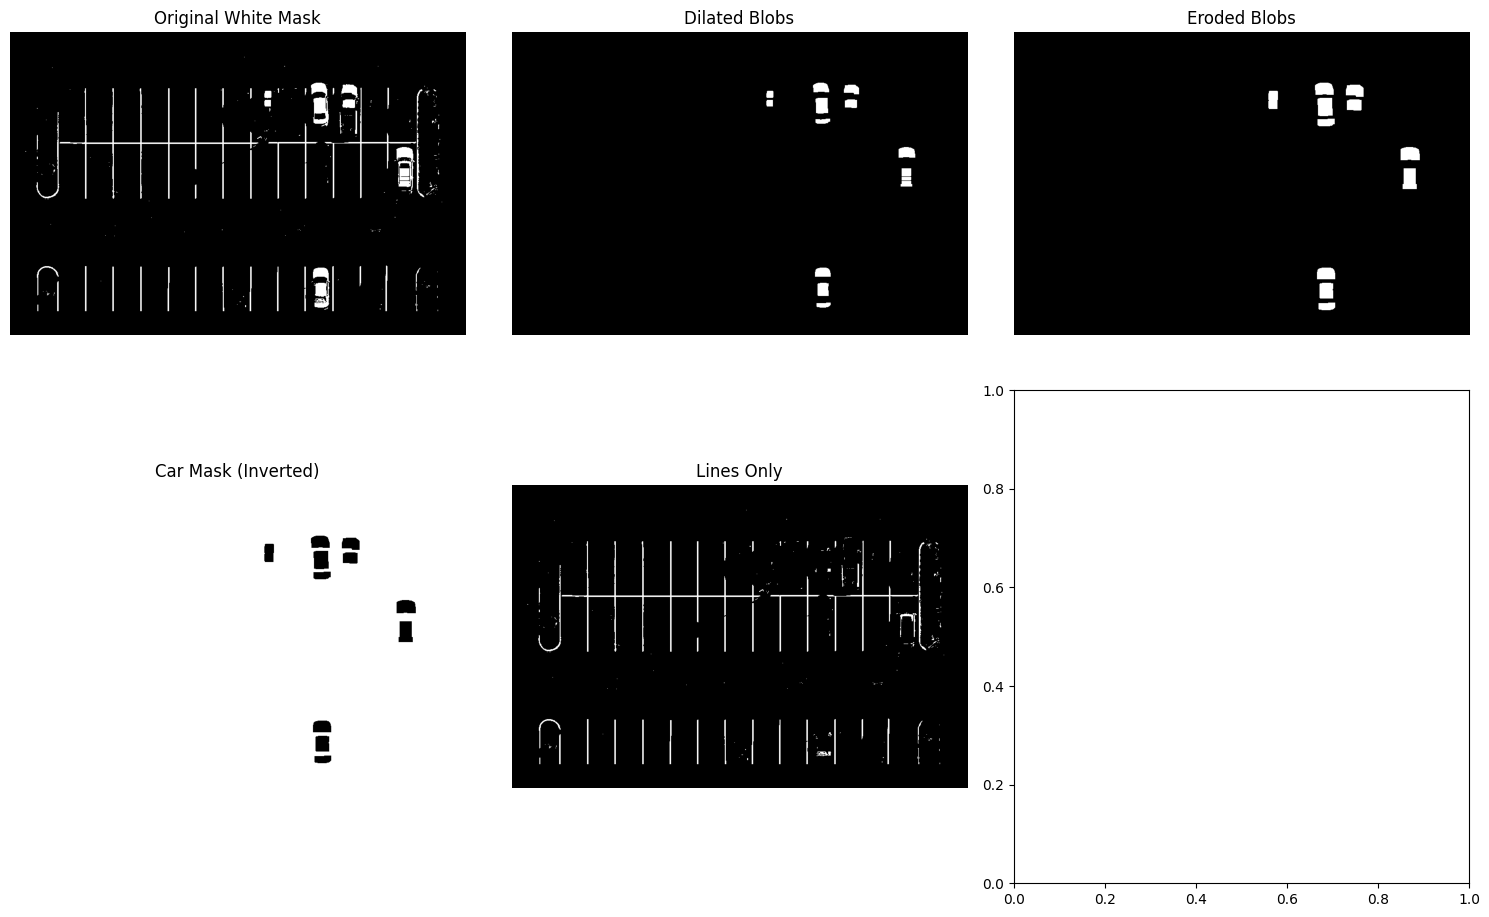

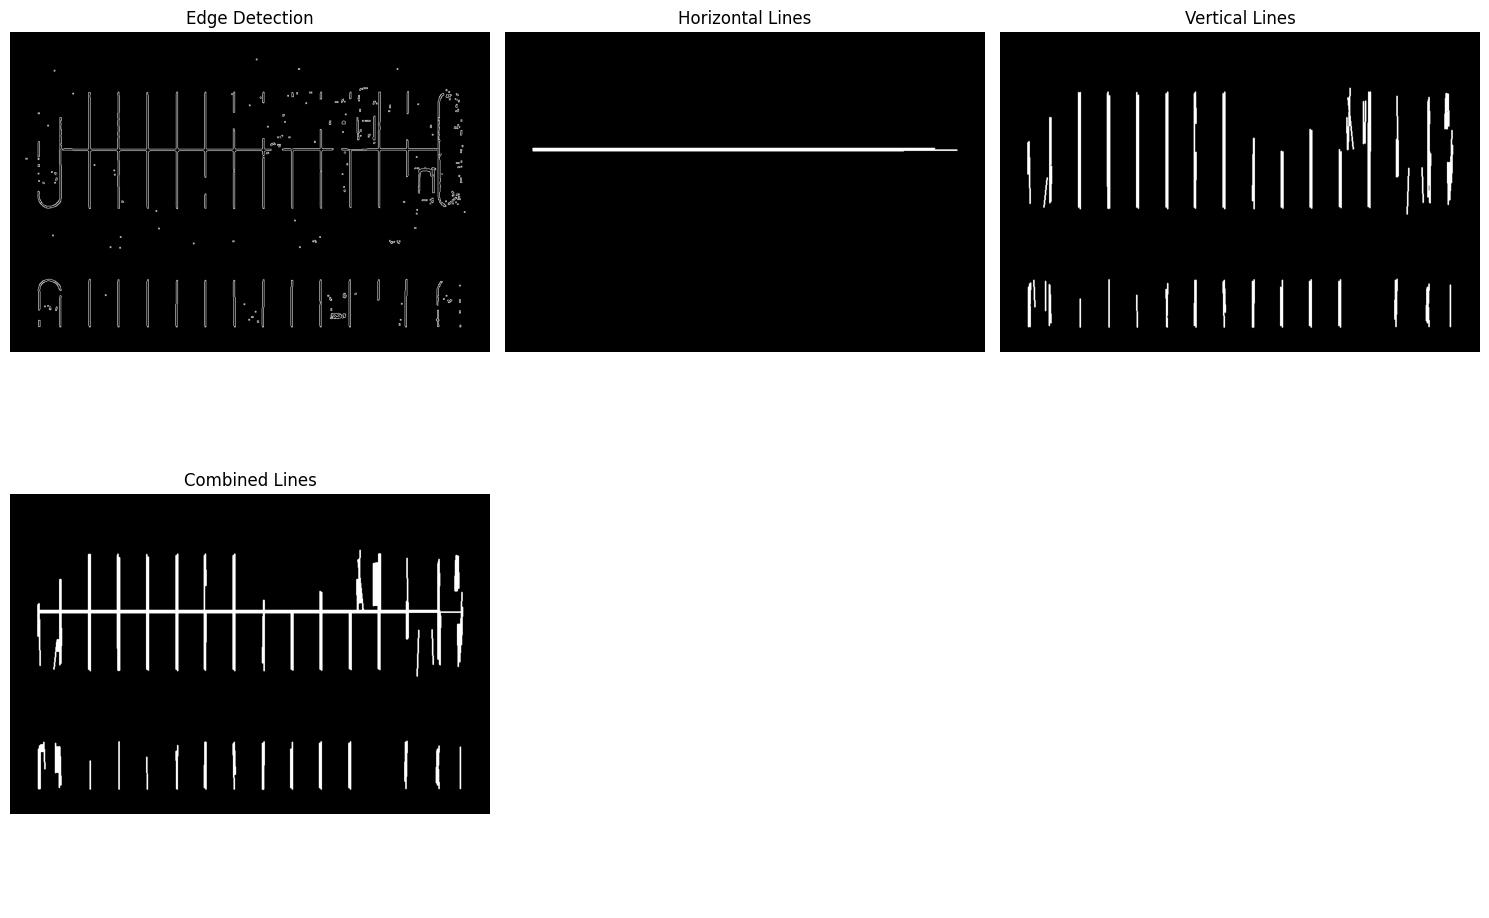

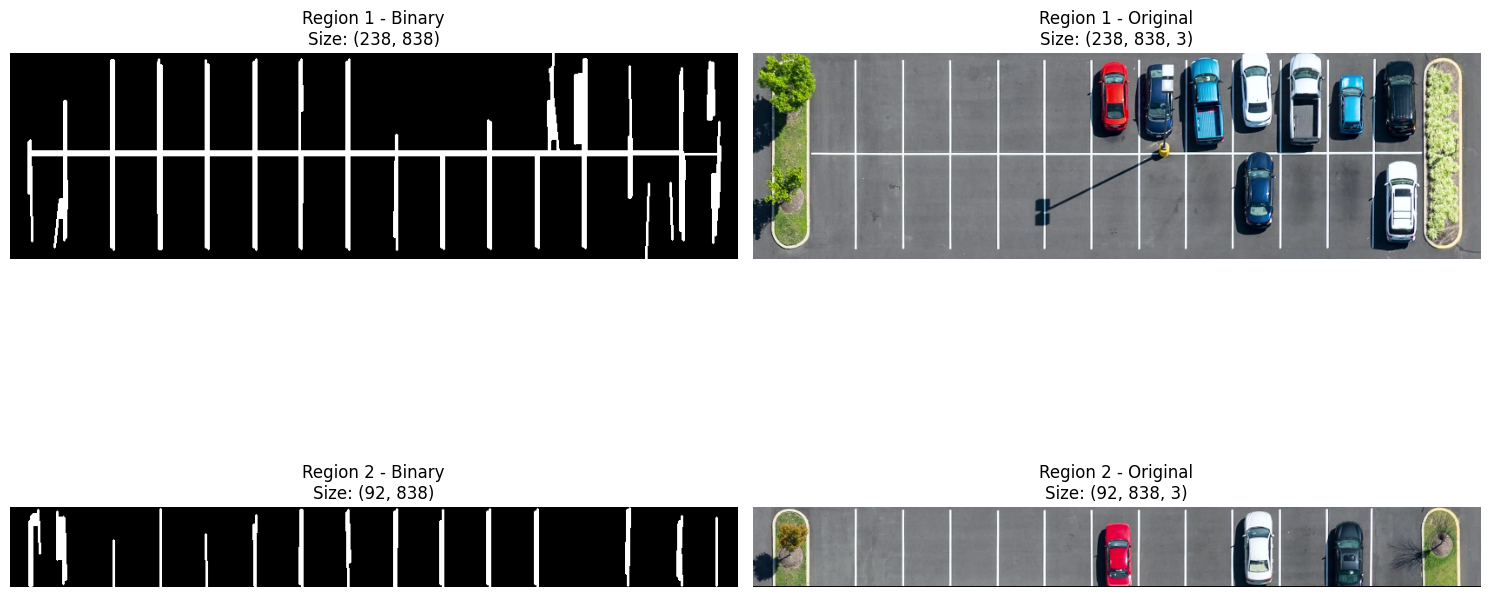

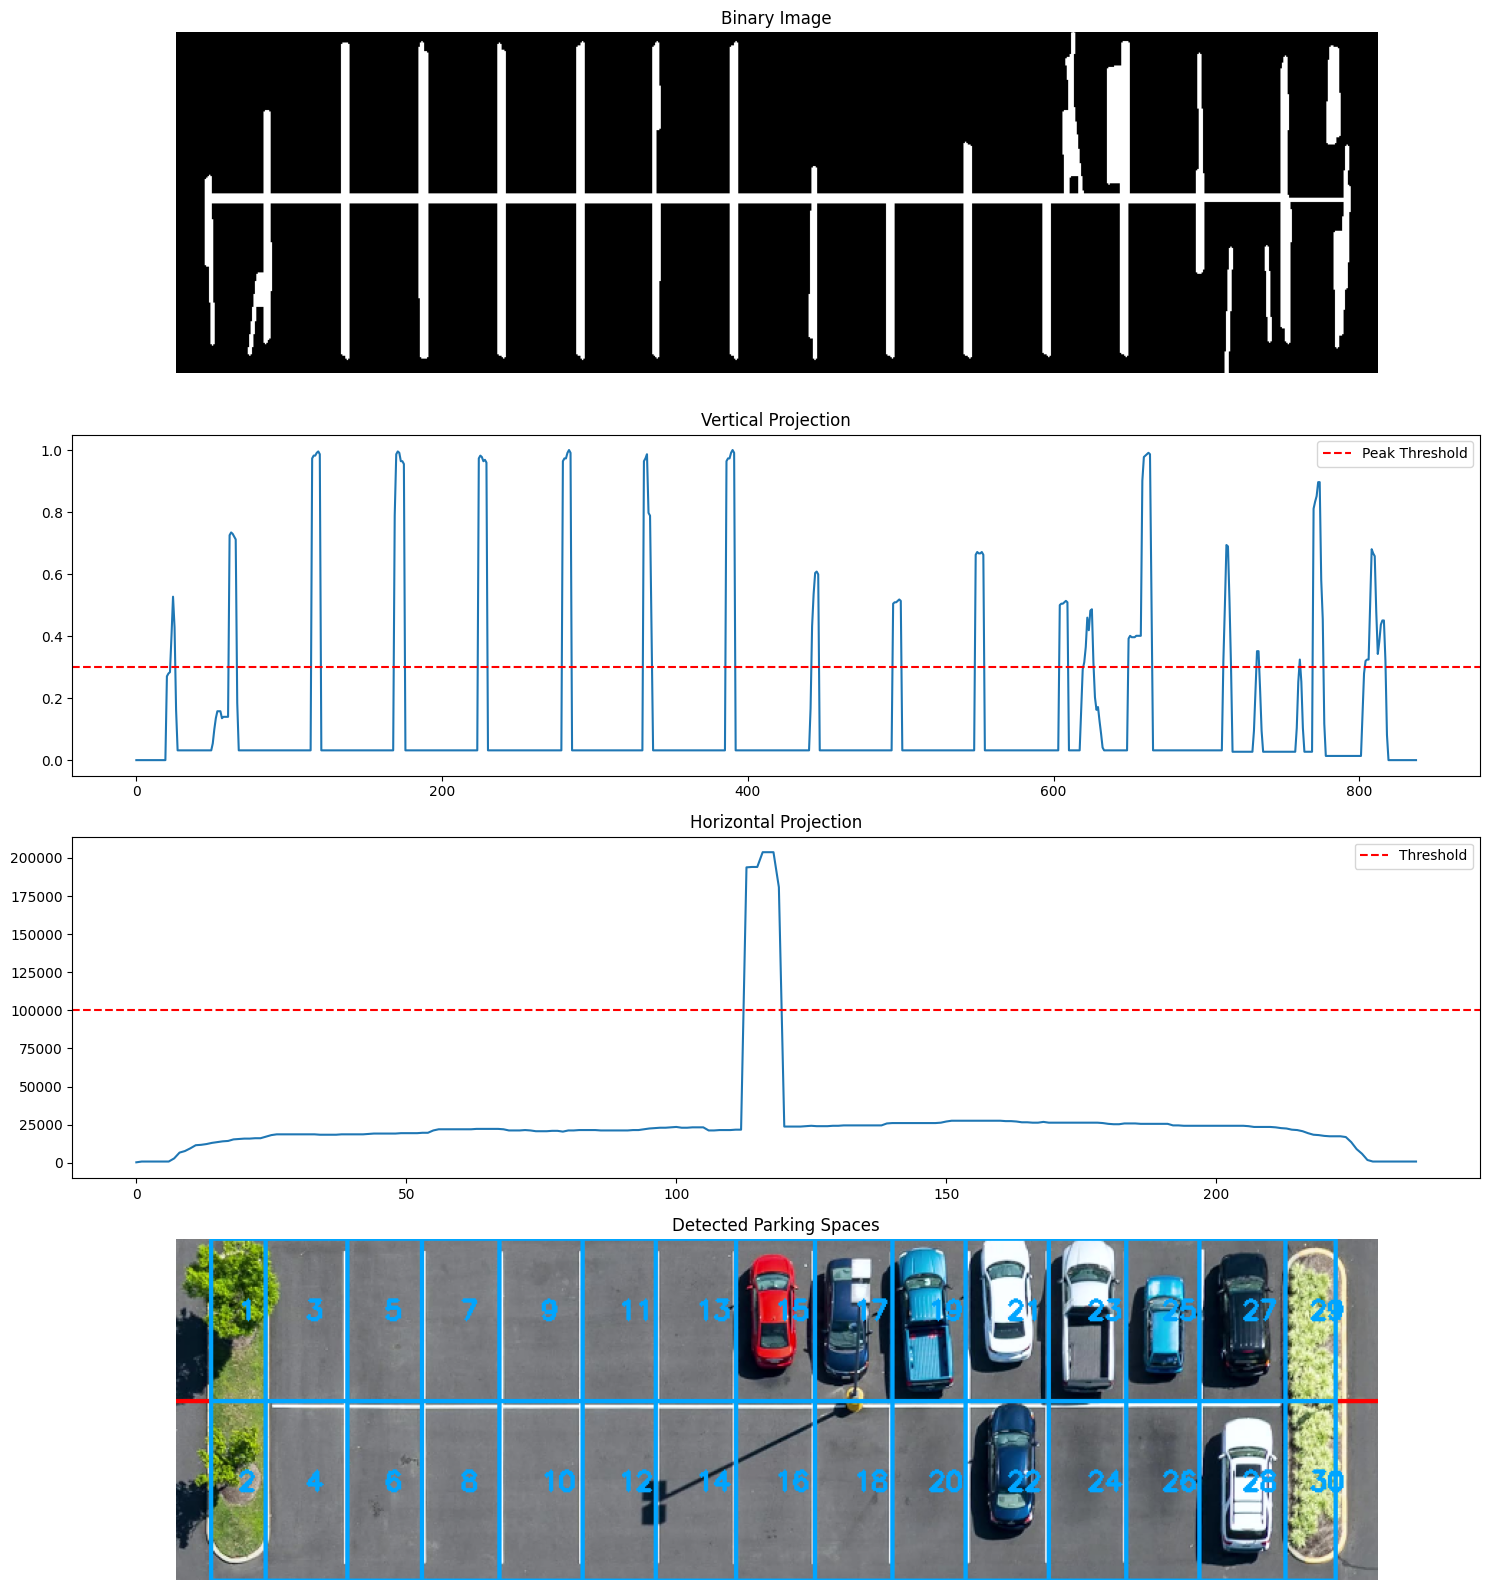


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 650.41, Mean Intensity: 125.23, Edge density: 0.067
Bottom half:
Space 1 Bottom - Variance: 1181.52, Mean Intensity: 132.51, Edge density: 0.035

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 1470.44, Mean Intensity: 139.97, Edge density: 0.063
Bottom half:
Space 2 Bottom - Variance: 809.30, Mean Intensity: 130.61, Edge density: 0.027

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 27.41, Mean Intensity: 123.76, Edge density: 0.003
Bottom half:
Space 3 Bottom - Variance: 55.92, Mean Intensity: 123.83, Edge density: 0.019

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 622.58, Mean Intensity: 130.83, Edge density: 0.065
Bottom half:
Space 4 Bottom - Variance: 121.22, Mean Intensity: 124.25, Edge density: 0.025

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 493.57, Mean Intensity: 130.65, Edge density: 0.018
Bottom half:
Space 5 Bottom - Variance: 607.98, Mean Intensity: 129.52, Edge density: 0.027

Analyzing

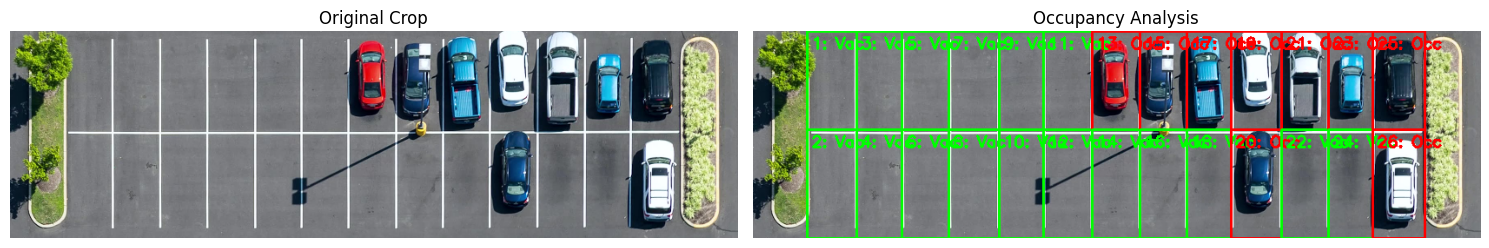

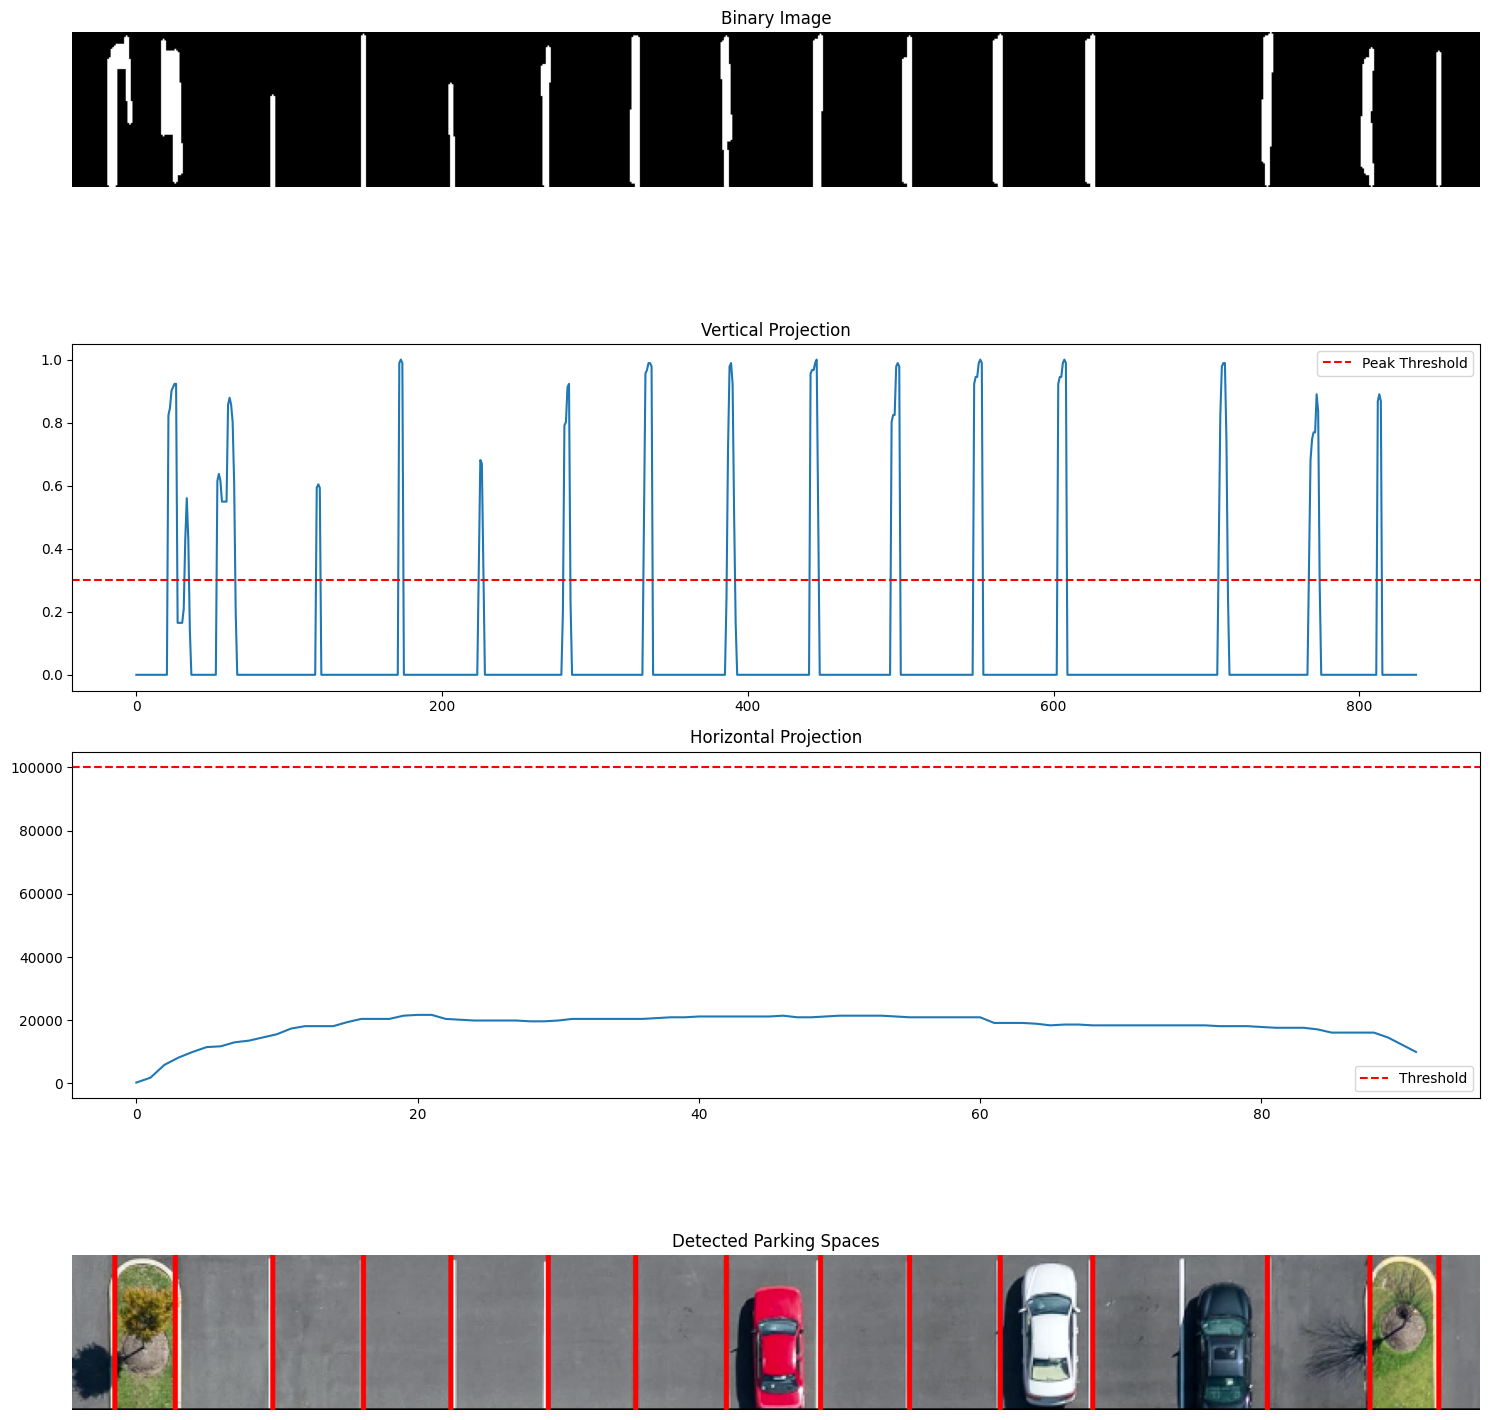


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 2185.02, Mean Intensity: 120.85, Edge density: 0.341
Bottom half:
Space 1 Bottom - Variance: 1433.89, Mean Intensity: 122.82, Edge density: 0.316

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 852.40, Mean Intensity: 135.13, Edge density: 0.042
Bottom half:
Space 2 Bottom - Variance: 1395.17, Mean Intensity: 142.57, Edge density: 0.072

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 389.69, Mean Intensity: 129.85, Edge density: 0.036
Bottom half:
Space 3 Bottom - Variance: 746.27, Mean Intensity: 131.99, Edge density: 0.058

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 289.54, Mean Intensity: 128.10, Edge density: 0.018
Bottom half:
Space 4 Bottom - Variance: 675.54, Mean Intensity: 128.20, Edge density: 0.040

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 966.34, Mean Intensity: 133.23, Edge density: 0.049
Bottom half:
Space 5 Bottom - Variance: 1397.51, Mean Intensity: 135.27, Edge density: 0.071

Analy

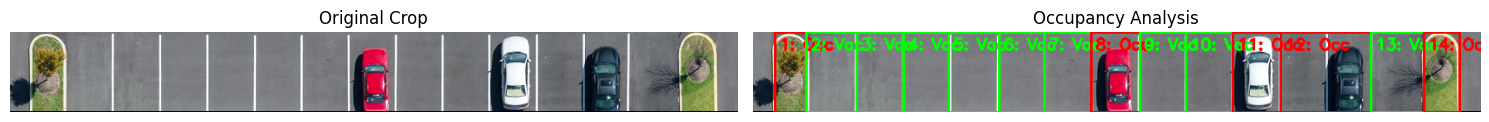

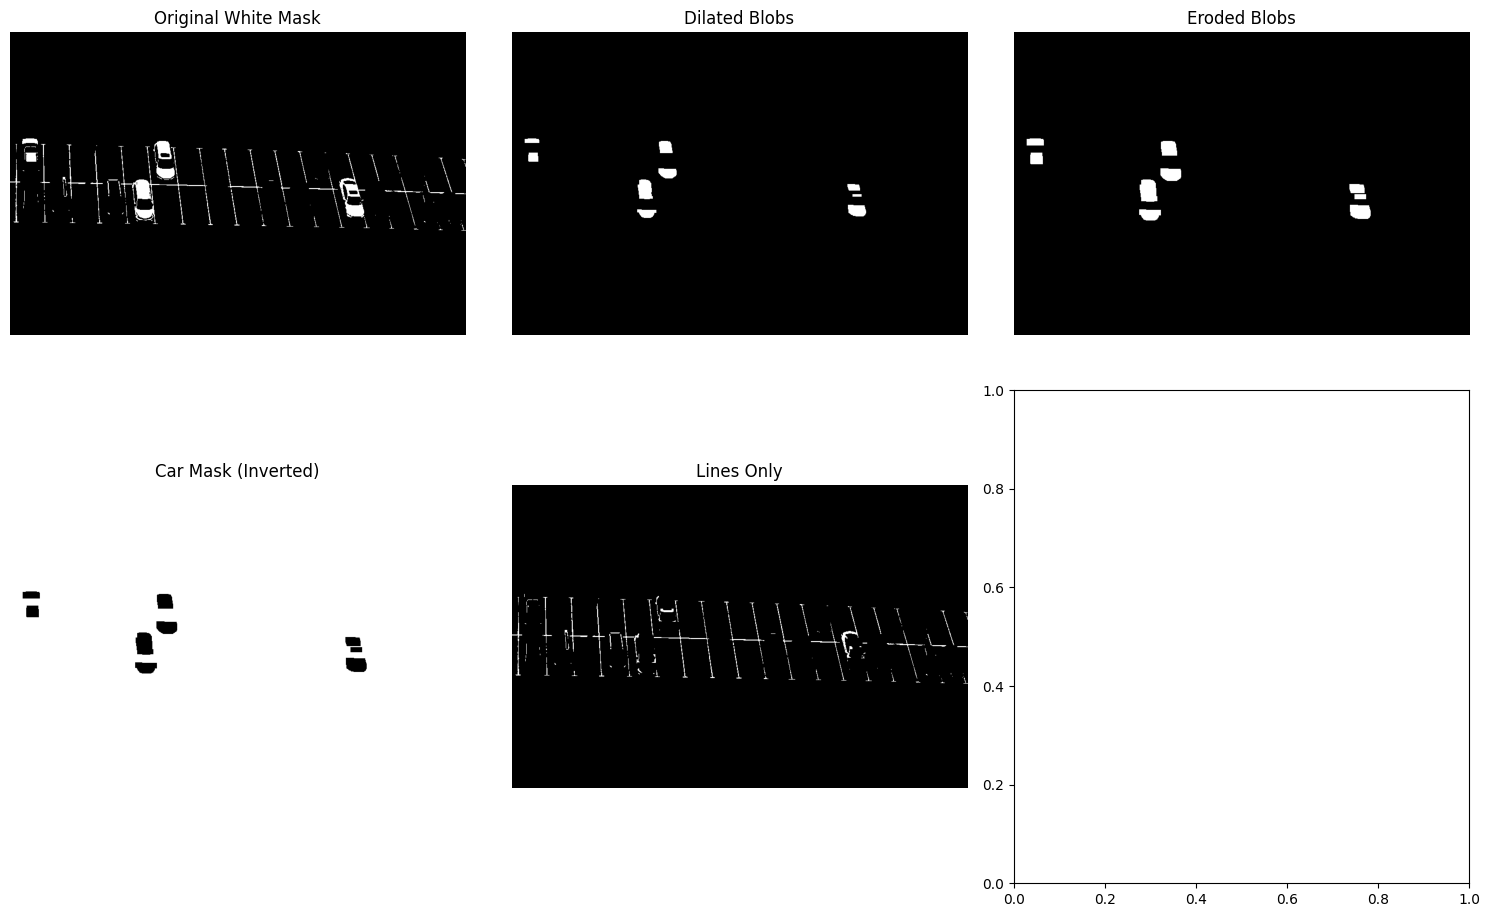

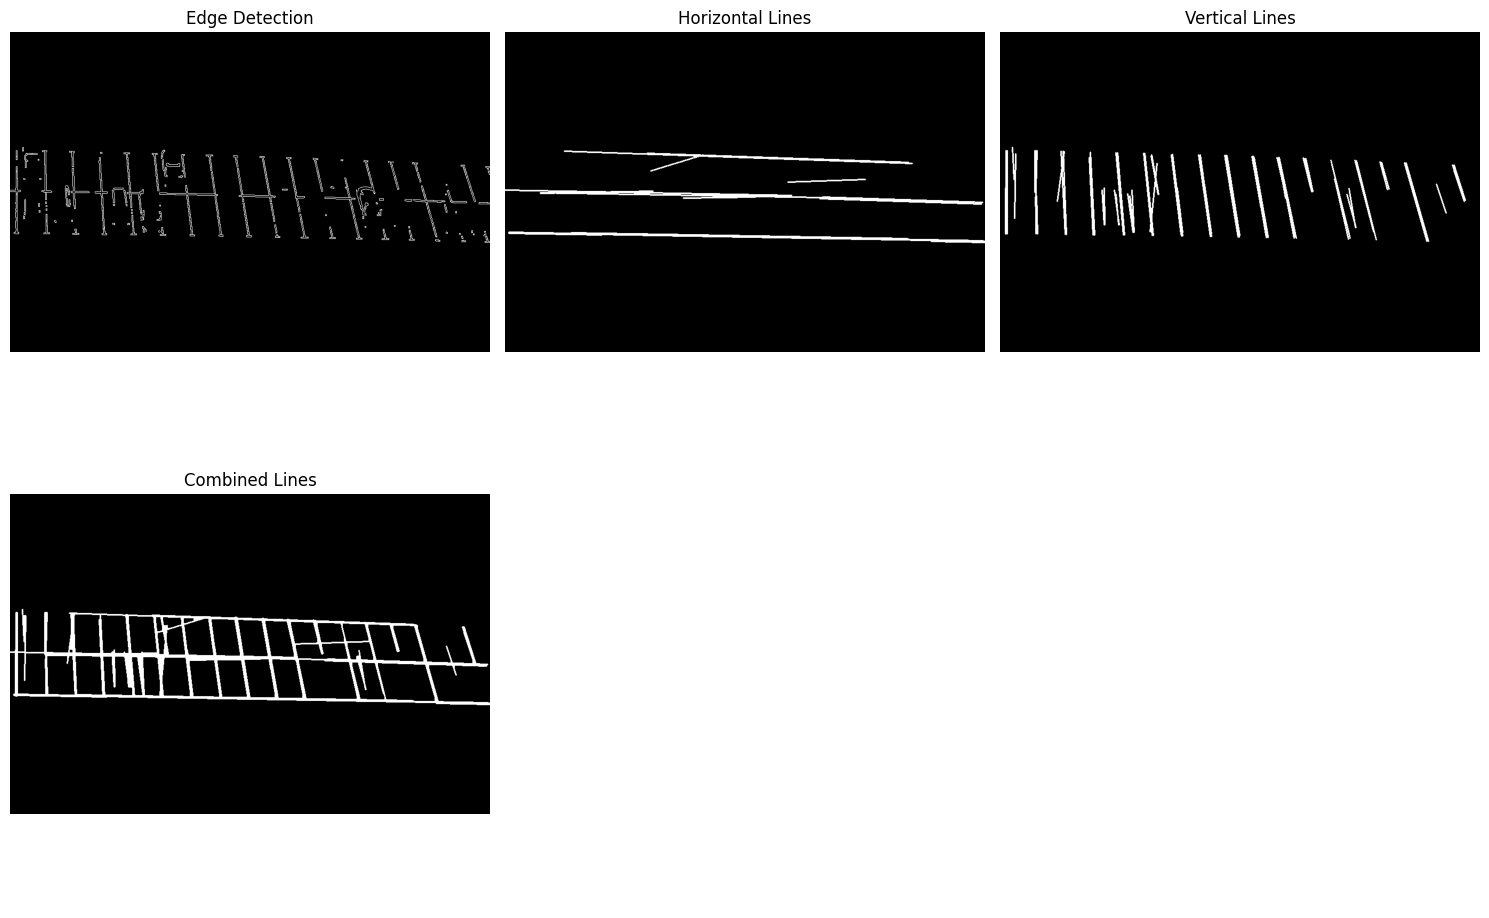

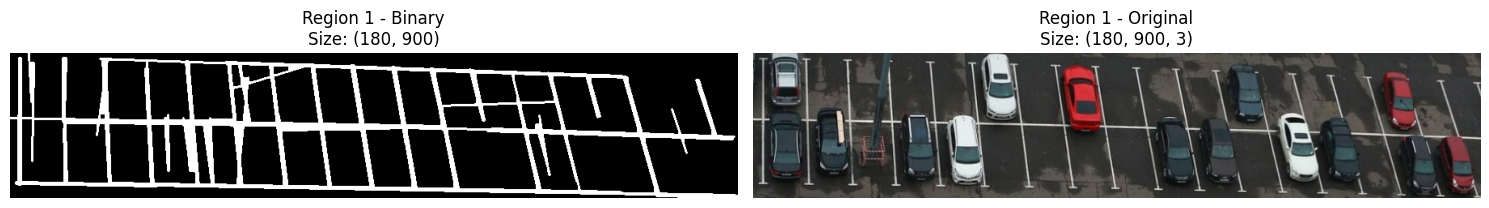

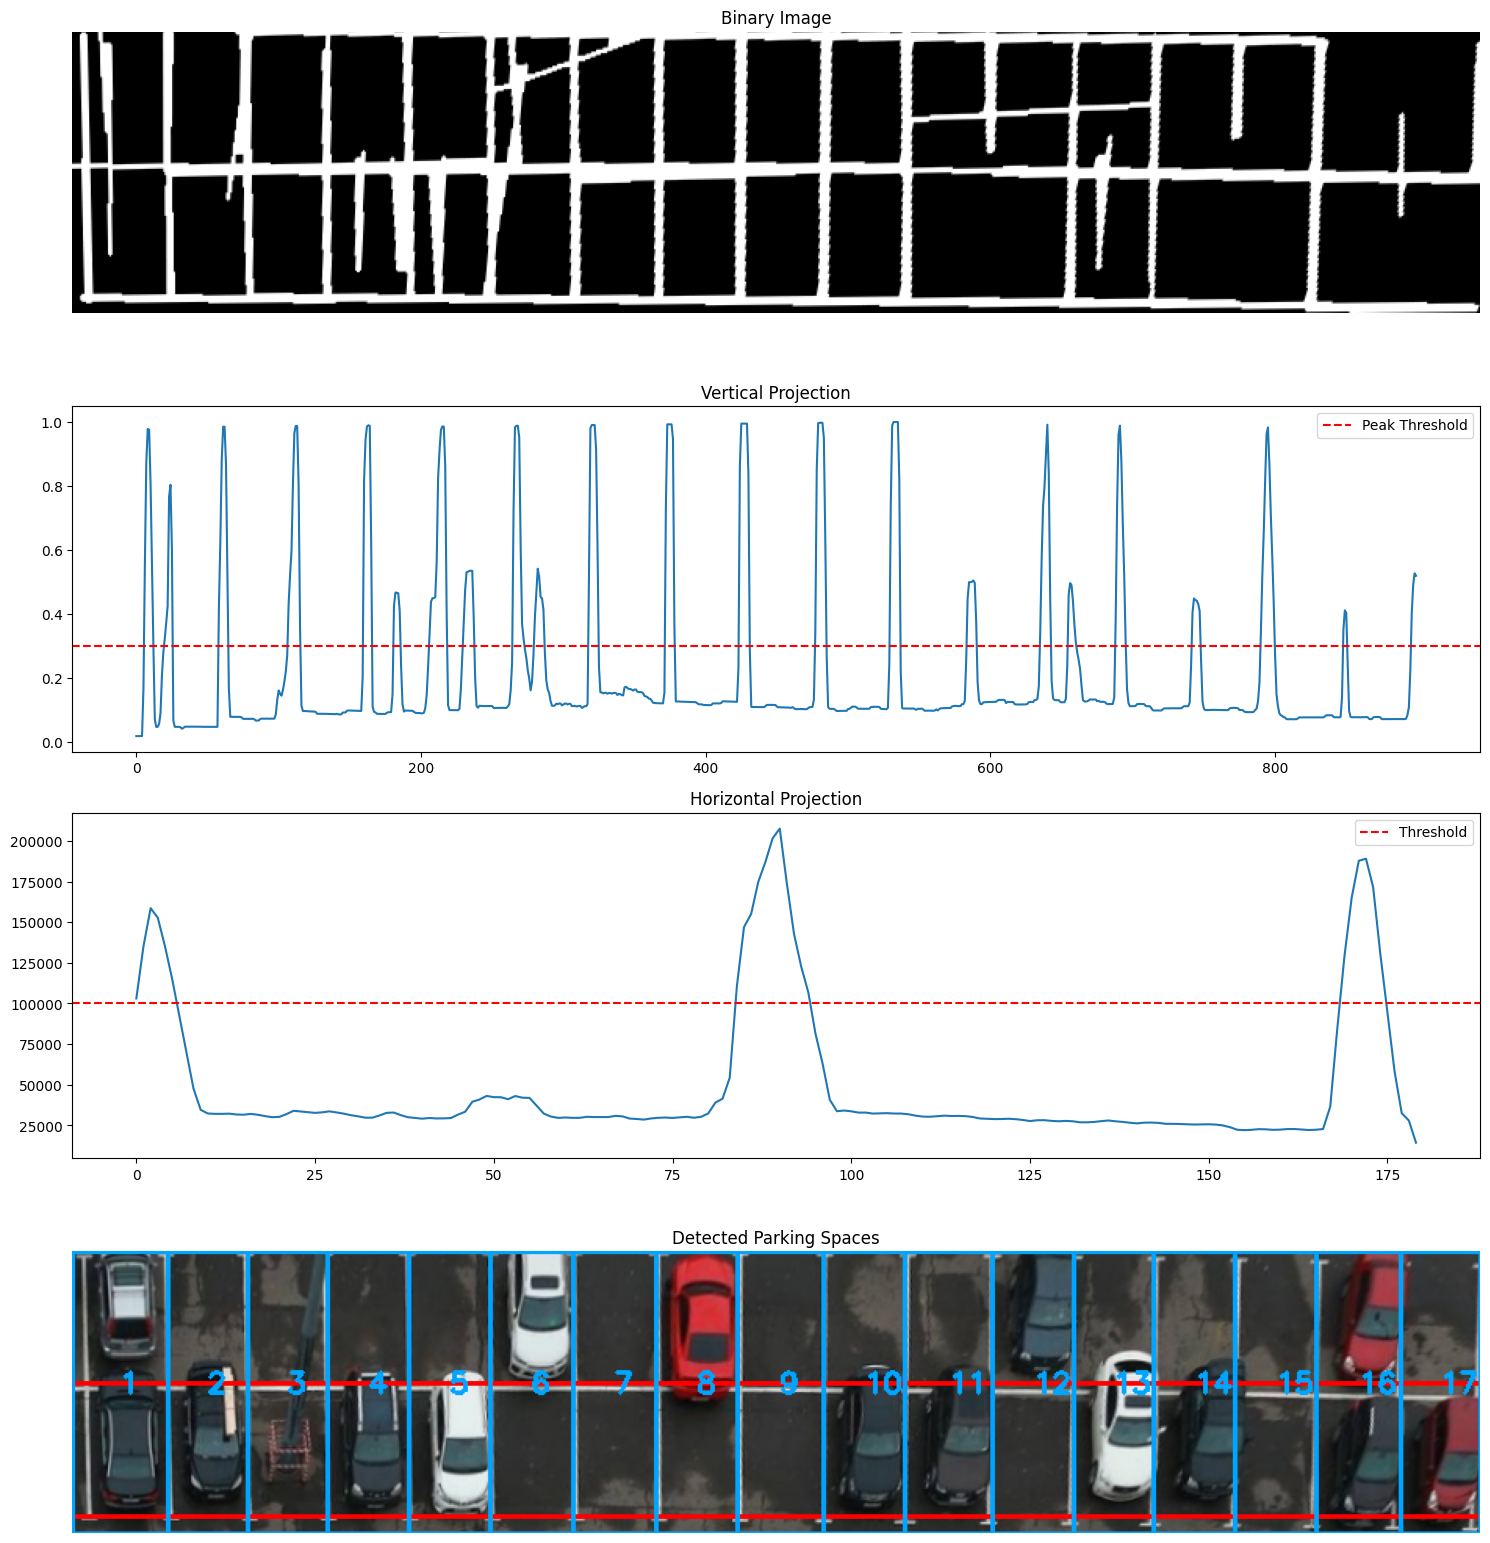


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 3338.73, Mean Intensity: 91.87, Edge density: 0.237
Bottom half:
Space 1 Bottom - Variance: 1232.51, Mean Intensity: 58.46, Edge density: 0.169

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 1177.45, Mean Intensity: 59.00, Edge density: 0.192
Bottom half:
Space 2 Bottom - Variance: 1033.33, Mean Intensity: 53.09, Edge density: 0.134

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 821.44, Mean Intensity: 58.79, Edge density: 0.091
Bottom half:
Space 3 Bottom - Variance: 1390.17, Mean Intensity: 79.23, Edge density: 0.135

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 2731.90, Mean Intensity: 74.42, Edge density: 0.163
Bottom half:
Space 4 Bottom - Variance: 949.67, Mean Intensity: 47.50, Edge density: 0.117

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 660.26, Mean Intensity: 70.29, Edge density: 0.127
Bottom half:
Space 5 Bottom - Variance: 1037.80, Mean Intensity: 65.61, Edge density: 0.095

Analyzing Sp

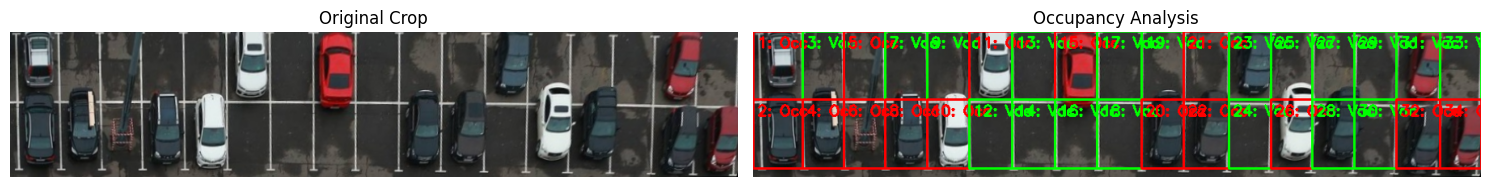

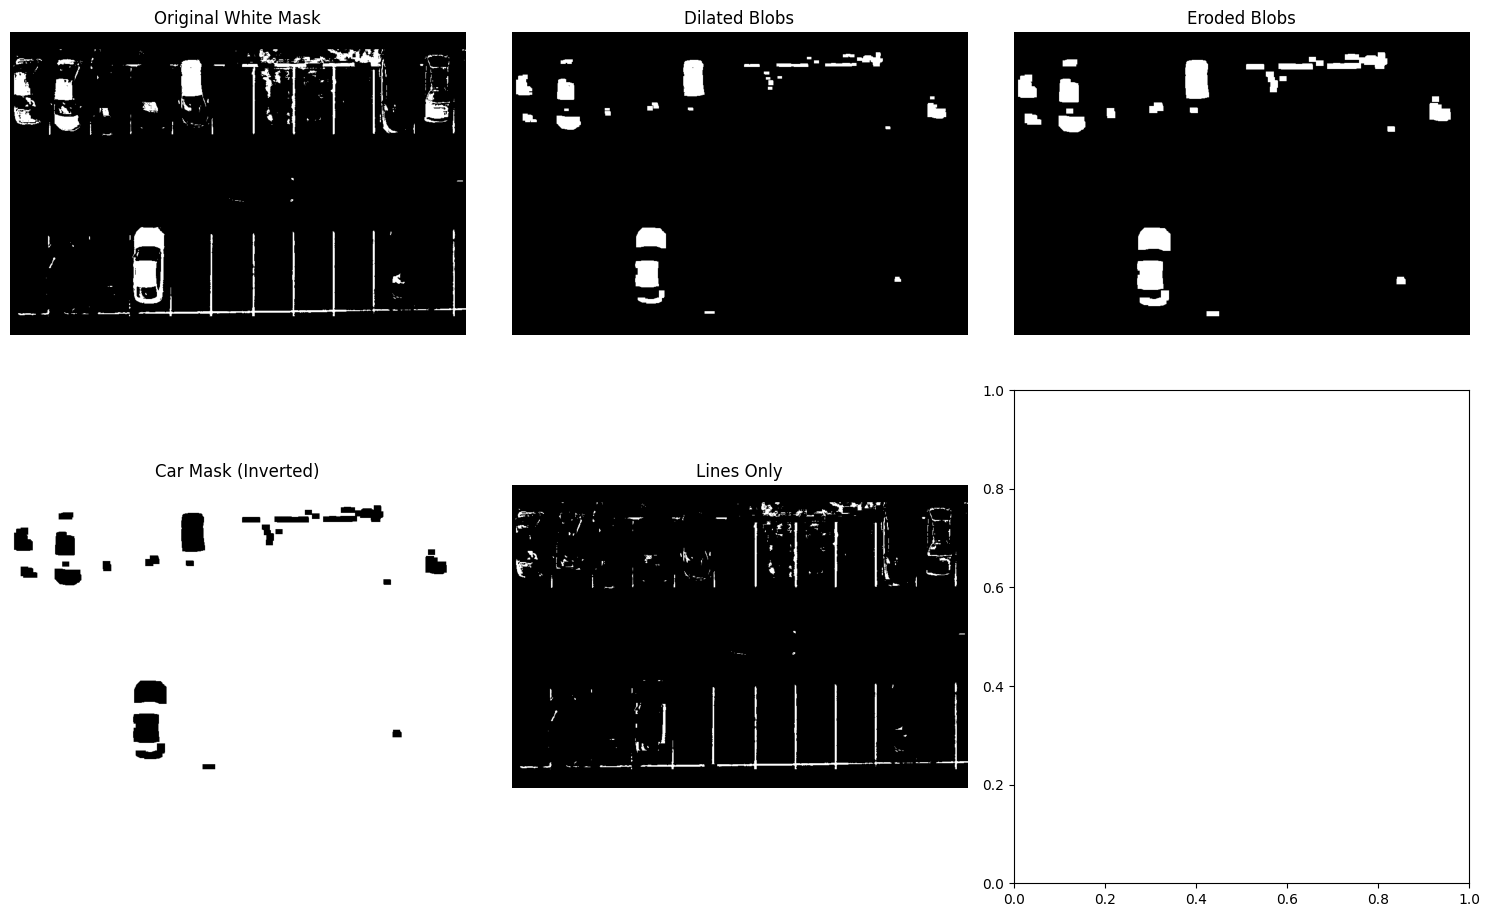

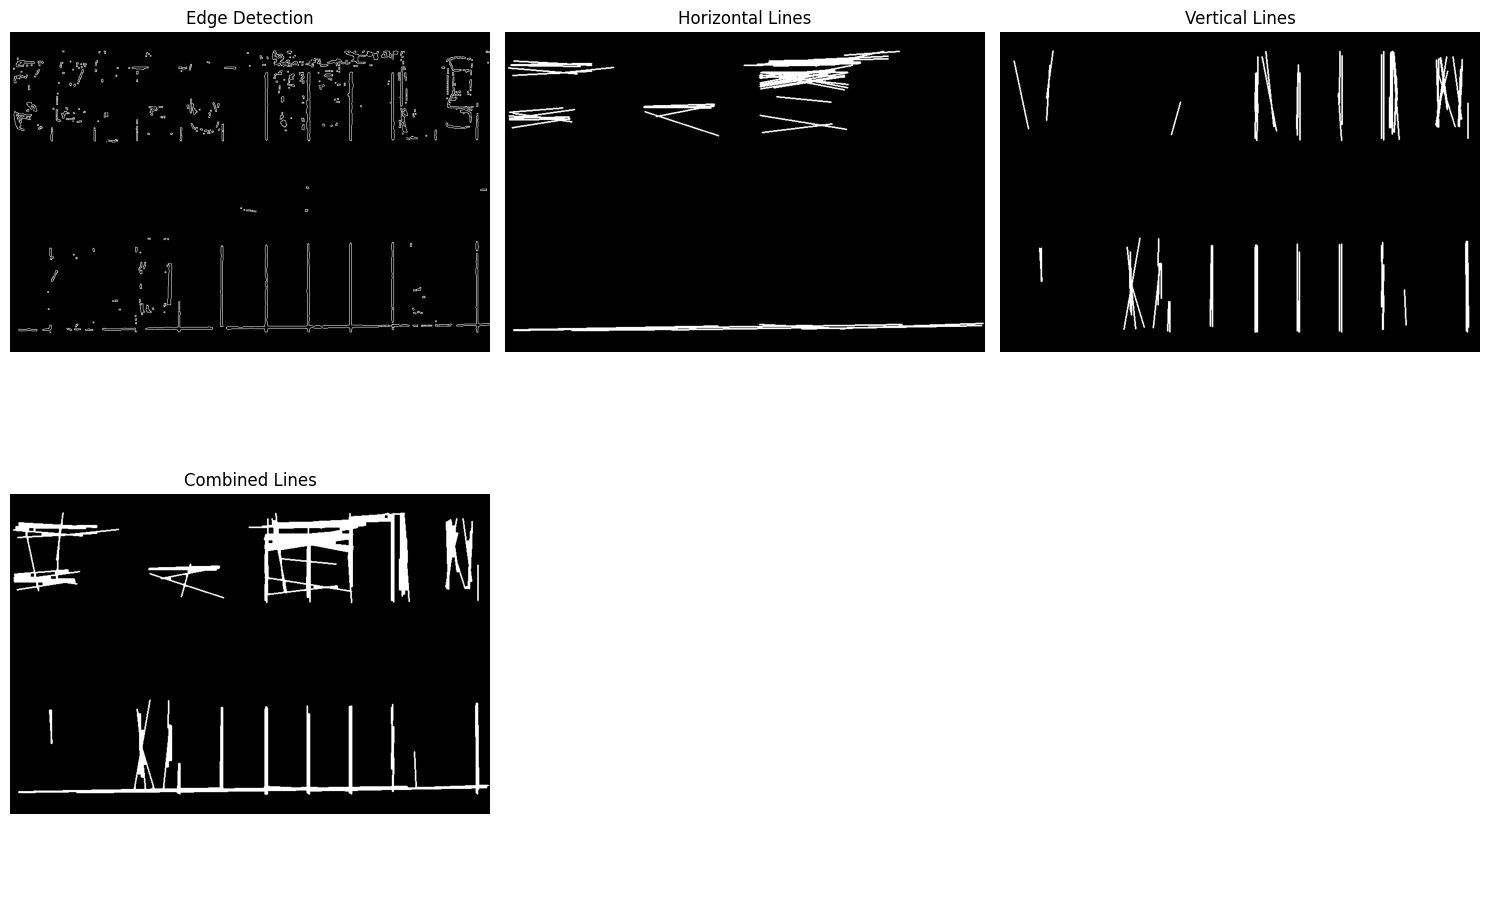

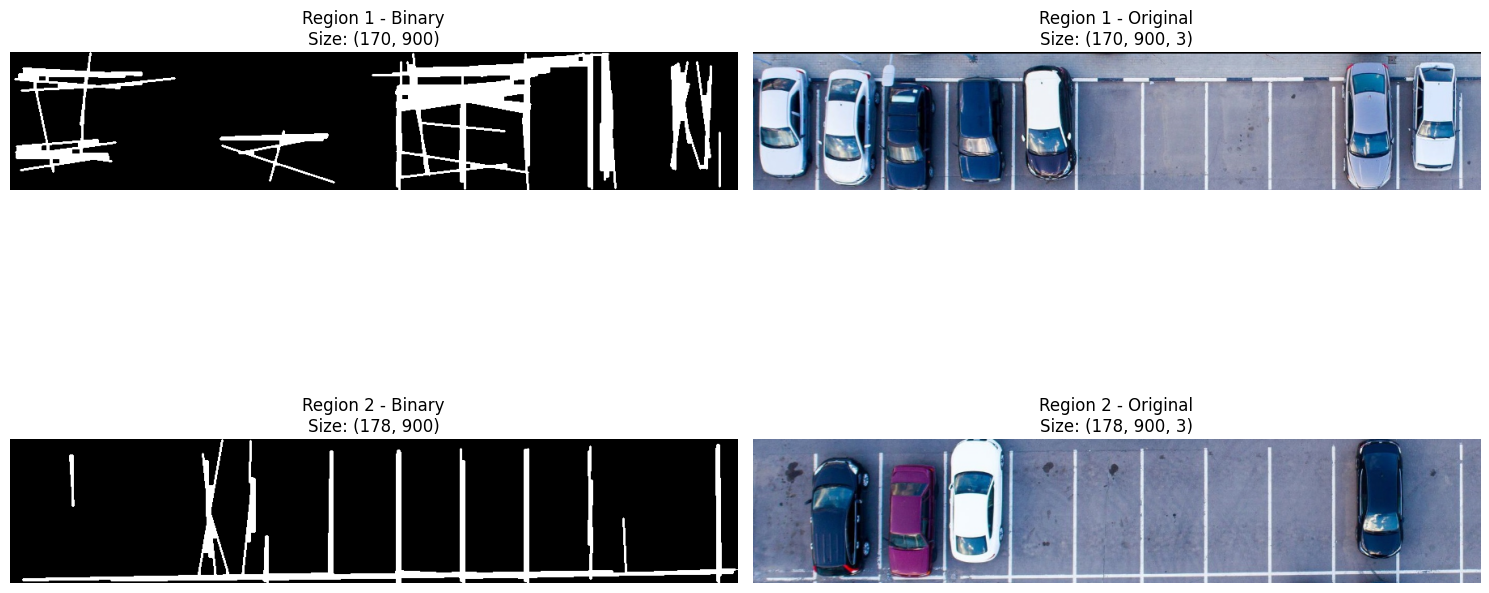

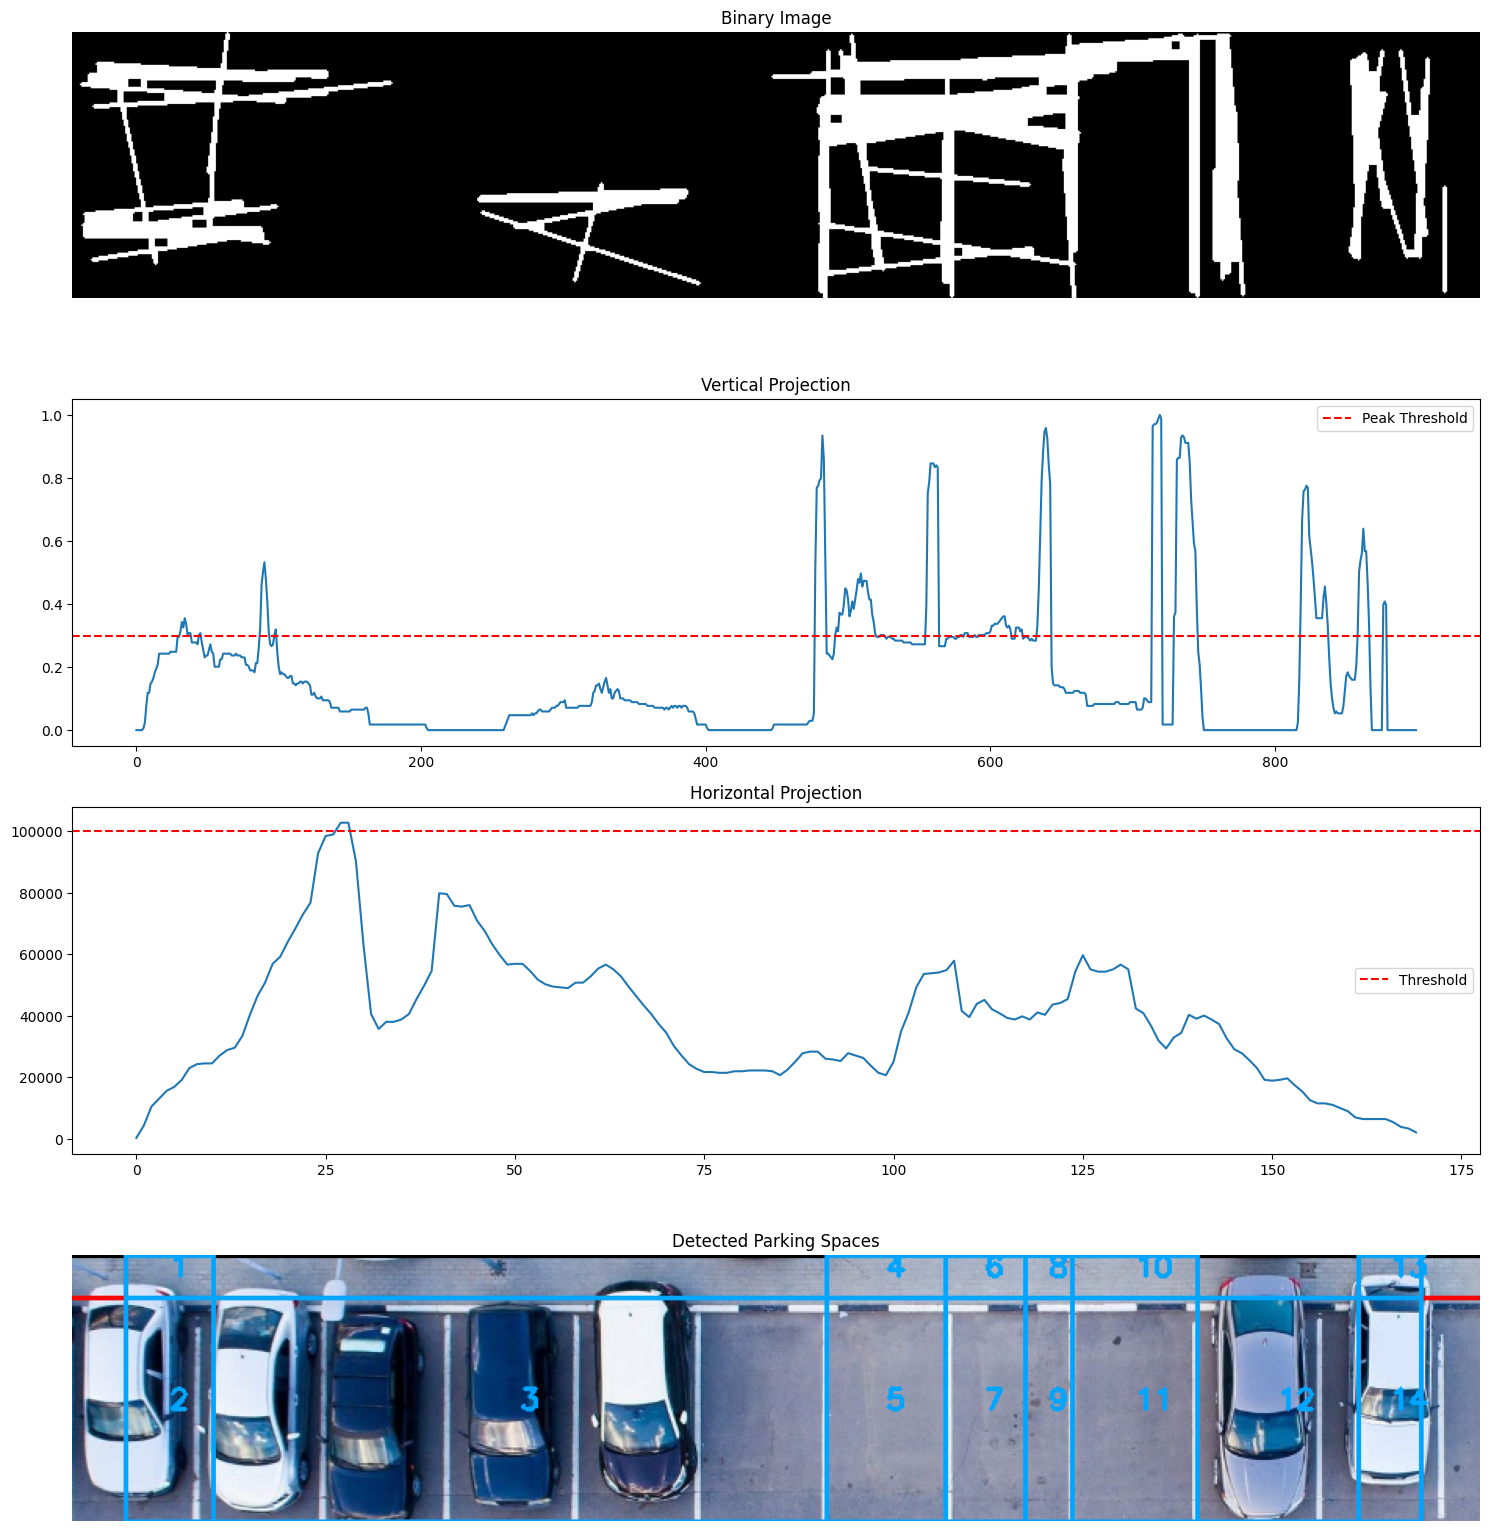


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 5086.58, Mean Intensity: 107.98, Edge density: 0.185
Bottom half:
Space 1 Bottom - Variance: 4668.26, Mean Intensity: 132.01, Edge density: 0.163

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 5770.75, Mean Intensity: 110.66, Edge density: 0.111
Bottom half:
Space 2 Bottom - Variance: 3408.74, Mean Intensity: 103.21, Edge density: 0.141

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 525.98, Mean Intensity: 158.21, Edge density: 0.043
Bottom half:
Space 3 Bottom - Variance: 180.54, Mean Intensity: 149.49, Edge density: 0.017

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 724.91, Mean Intensity: 161.69, Edge density: 0.062
Bottom half:
Space 4 Bottom - Variance: 492.35, Mean Intensity: 154.14, Edge density: 0.066

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 945.30, Mean Intensity: 147.09, Edge density: 0.058
Bottom half:
Space 5 Bottom - Variance: 480.18, Mean Intensity: 145.94, Edge density: 0.026

Analy

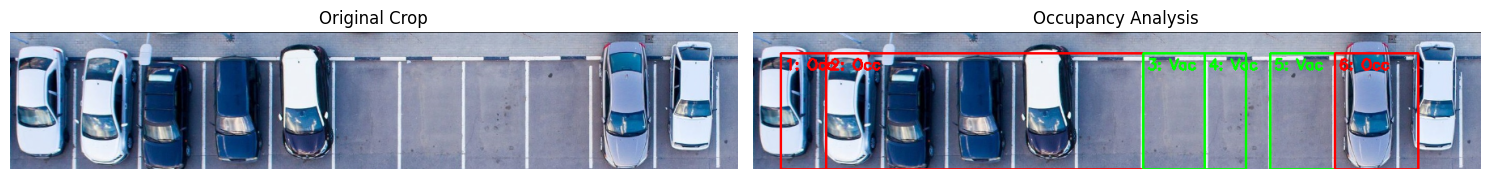

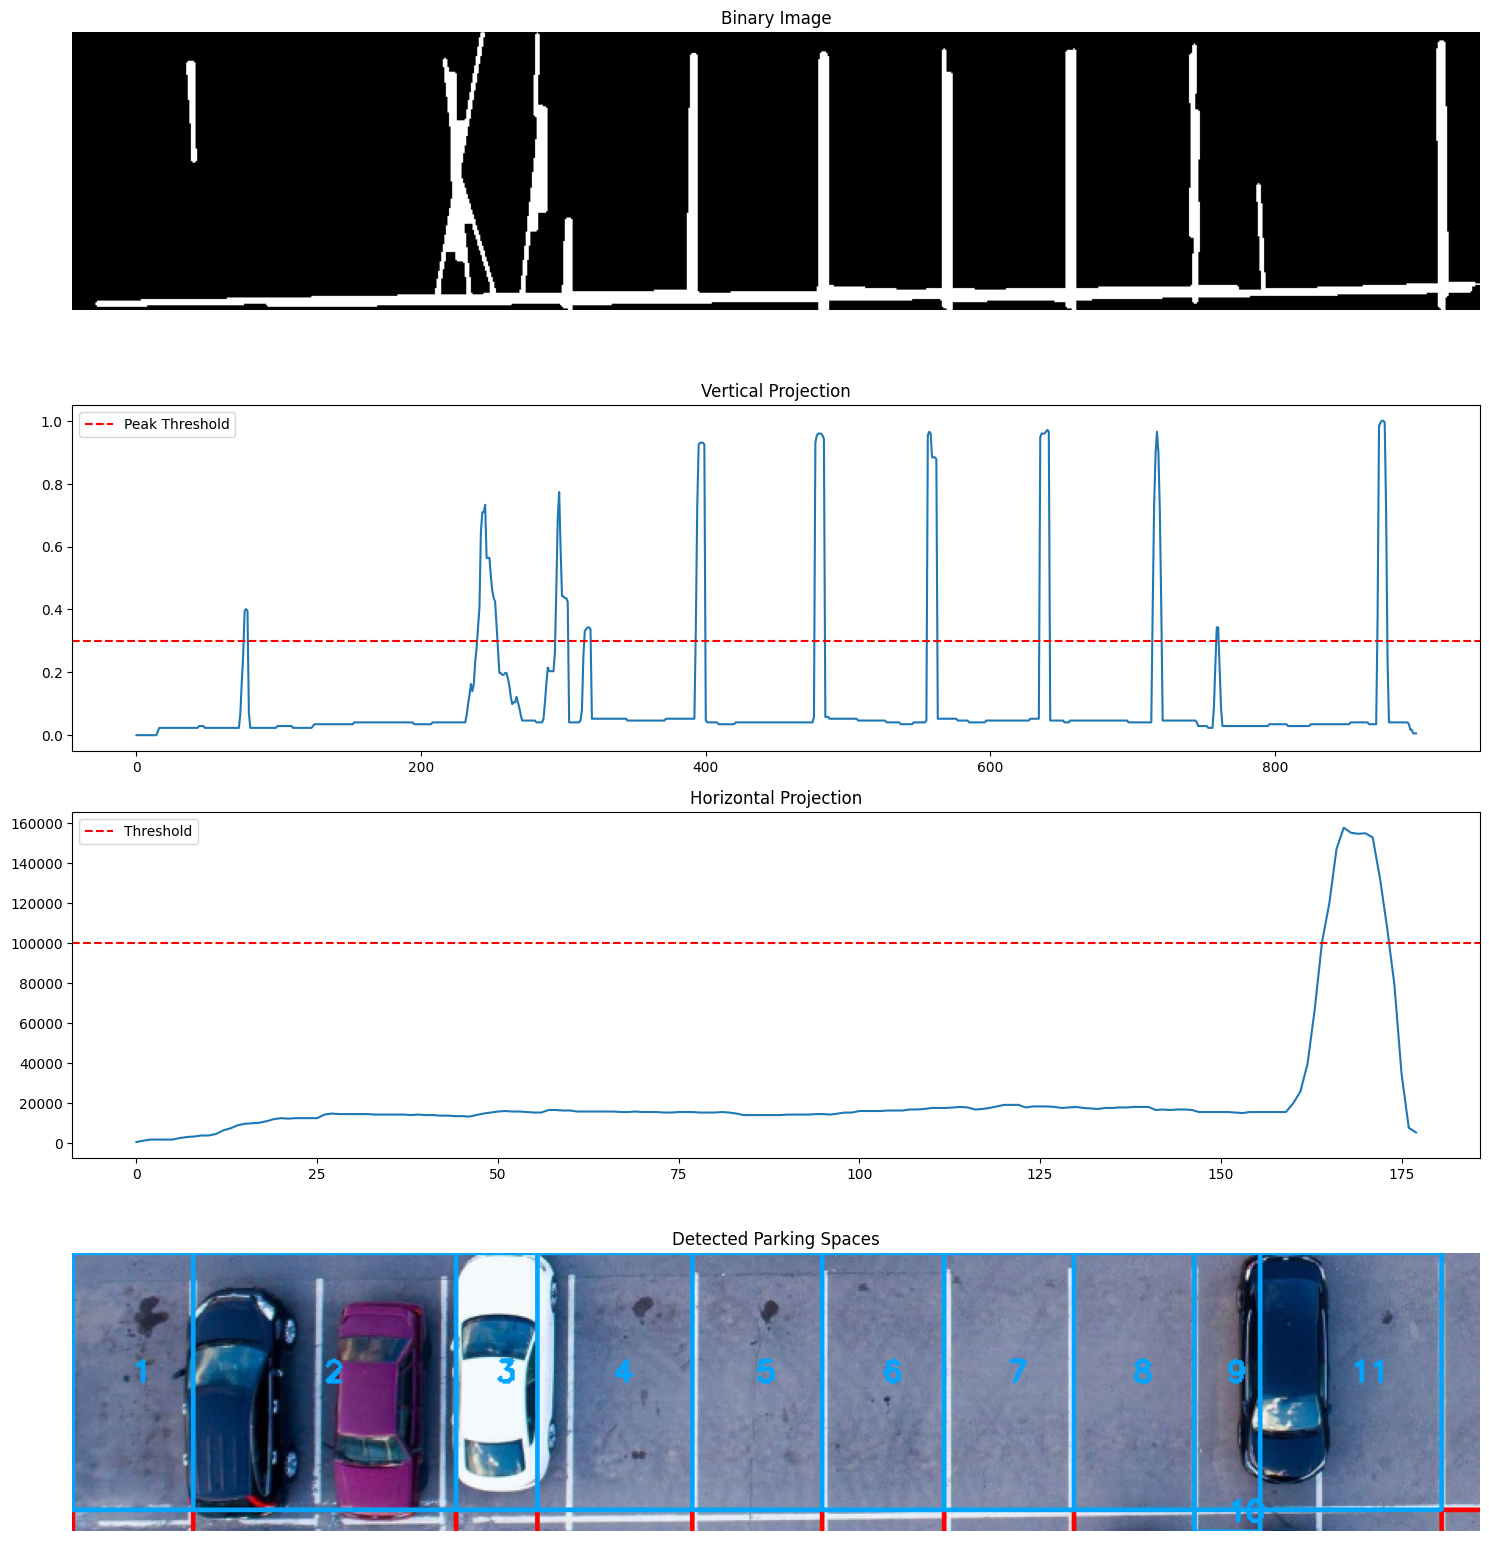


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 455.75, Mean Intensity: 113.97, Edge density: 0.063
Bottom half:
Space 1 Bottom - Variance: 291.99, Mean Intensity: 113.23, Edge density: 0.036

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 1614.32, Mean Intensity: 78.59, Edge density: 0.102
Bottom half:
Space 2 Bottom - Variance: 1512.99, Mean Intensity: 58.99, Edge density: 0.144

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 6458.96, Mean Intensity: 186.44, Edge density: 0.127
Bottom half:
Space 3 Bottom - Variance: 5080.82, Mean Intensity: 188.10, Edge density: 0.117

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 1651.40, Mean Intensity: 126.33, Edge density: 0.055
Bottom half:
Space 4 Bottom - Variance: 1157.19, Mean Intensity: 136.37, Edge density: 0.071

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 475.02, Mean Intensity: 130.77, Edge density: 0.045
Bottom half:
Space 5 Bottom - Variance: 418.72, Mean Intensity: 141.99, Edge density: 0.029

Analy

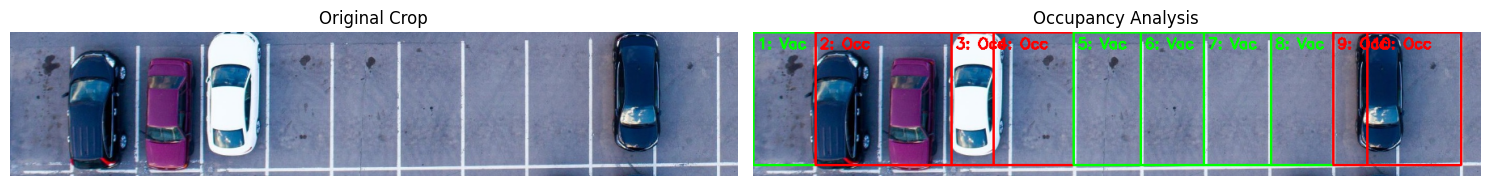

In [14]:
# Main processing loop
%matplotlib inline
image_dir = 'c:/Users/Patrick/Documents/EmbeddedImageProcessing/Mini-Project/Mini_project_images/medium/*'
image_files = [file for file in glob(image_dir, recursive=True) if file.endswith(('.jpg', '.png'))]
all_results = []    

for i, file in enumerate(image_files):
    original_img = cv2.imread(file)
    standardized = standardize_image(original_img)
    parking_spaces = detect_white_lines(standardized)
    parking_lines = detect_parking_lines(parking_spaces)
    
    binary_crops, original_crops, crop_coordinates = crop_parking_regions(parking_lines, standardized)

    #distortion correction
    if i == 1: ##if the image that needs distortion correction
        warped_image = get_birds_eye_view(binary_crops[0])
        #Resize warped_image to match binary_crops[0]
        warped_image = cv2.resize(warped_image, 
                                dsize=binary_crops[0].shape[::-1], 
                                interpolation=cv2.INTER_LINEAR) 

        binary_crops[0] = warped_image 

        warped_original = get_birds_eye_view(original_crops[0])
        #Resize warped_original to match original_crops[0] 
        warped_original = cv2.resize(warped_original, 
                             dsize=(original_crops[0].shape[1], original_crops[0].shape[0]), 
                             interpolation=cv2.INTER_LINEAR)
        original_crops[0] = warped_original

    for binary_crop, original_crop in zip(binary_crops, original_crops):
        # Get the peaks from detect_parking_spaces
        v_peaks, h_peaks, _  = detect_parking_spaces(binary_crop, original_crop)
        # Use those peaks directly to extract spots
        spots = extract_parking_spots(original_crop, v_peaks, h_peaks)
        cv2.waitKey(1000)
        occupancy_results, annotated_img = analyze_parking_spot_occupancy(original_crop, spots)
        all_results.extend(occupancy_results)